In [1]:
%cd /home/mrearle/repos/R2R-EnvDrop-ObjAttn/

/mnt-homes/kraken/mrearle/repos/R2R-EnvDrop-ObjAttn


# Arguments

In [2]:
import sys
import torch

metadata_parser_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser'
if metadata_parser_path not in sys.path:
    sys.path.append(metadata_parser_path)

mattersim_path = '/home/mrearle/datasets/Matterport3DSimulator/build'
if mattersim_path not in sys.path:
    sys.path.append(mattersim_path)
    
src_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src'
if src_path not in sys.path:
    sys.path.append(src_path)

sys.path

['/home/mrearle/venvs/r2r/lib/python36.zip',
 '/home/mrearle/venvs/r2r/lib/python3.6',
 '/home/mrearle/venvs/r2r/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/mrearle/venvs/r2r/lib/python3.6/site-packages',
 '/home/mrearle/venvs/r2r/lib/python3.6/site-packages/IPython/extensions',
 '/mnt-homes/kraken/mrearle/.ipython',
 '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser',
 '/home/mrearle/datasets/Matterport3DSimulator/build',
 '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src']

In [3]:
from parse_house_segmentations import HouseSegmentationFile

In [4]:
import os

class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

defaults = {
    'iters': 100000, 
    'name': 'default', 
    'train': 'speaker', 
    'maxInput': 80, 
    'maxDecode': 120, 
    'maxAction': 20, 
    'batchSize': 64, 
    'ignoreid': -100, 
    'feature_size': 2048, 
    'loadOptim': False, 
    'speaker': None, 
    'listener': None, 
    'load': None, 
    'aug': None, 
    'zero_init': False, 
    'ml_weight': 0.05, 
    'teacher_weight': 1.0, 
    'accumulate_grad': False, 
    'features': 'imagenet', 
    'featdropout': 0.3, 
    'self_train': False, 
    'candidates': 1, 
    'param_search': False, 
    'submit': False, 
    'beam': False, 
    'alpha': 0.5, 
    'optim': 'rms', 
    'lr': 0.0001, 
    'weight_decay': 0.0, 
    'dropout': 0.5, 
    'feedback': 'sample', 
    'teacher': 'final', 
    'epsilon': 0.1, 
    'rnn_dim': 512, 
    'wemb': 256, 
    'aemb': 64, 
    'proj': 512, 
    'fast_train': False, 
    'valid': False, 
    'candidate_mask': False,
    'bidir': True, 
    'encode': 'word', 
    'sub_out': 'tanh', 
    'attn': 'soft', 
    'angle_feat_size': 4, 
    'gamma': 0.9, 
    'normalize_loss': 'total', 
    'optimizer': 'rms', 
    'TRAIN_VOCAB': 'tasks/R2R/data/train_vocab.txt', 
    'TRAINVAL_VOCAB': 'tasks/R2R/data/trainval_vocab.txt', 
    'IMAGENET_FEATURES': 'img_features/ResNet-152-imagenet.tsv', 
    'CANDIDATE_FEATURES': 'img_features/ResNet-152-candidate.tsv', 
    'features_fast': 'img_features/ResNet-152-imagenet-fast.tsv', 
    'log_dir': 'snap/default'
}
args = Args(**defaults)
args.name = 'agent_bt_val'
args.attn = 'soft'
args.train = 'validlistener'
args.speaker = 'snap/speaker/state_dict/best_val_unseen_bleu'
args.load = 'snap/agent_obj_pruned/state_dict/best_val_unseen'
args.angle_feat_size = 128
args.accumulateGrad = True
args.featdropout = 0.4
args.subout = 'max'
args.optim = 'rms'
args.lr = 1e-4
args.iters = 10
args.maxAction = 35

args.TRAIN_VOCAB = "tasks/R2R/data/train_vocab.txt"
args.TRAINVAL_VOCAB = "tasks/R2R/data/trainval_vocab.txt"

args.IMAGENET_FEATURES = "img_features/ResNet-152-imagenet.tsv"
args.CANDIDATE_FEATURES = "img_features/ResNet-152-candidate.tsv"


args.OBJECT_FEATURES = "/home/mrearle/storage/img_features/ResNet-152-imagenet-conv.hdf5"
args.OBJECT_PROPOSALS = "/home/mrearle/storage/img_features/objProposals.json"

args.features_fast = "img_features/ResNet-152-imagenet-fast.tsv"
args.log_dir = "snap/%s" % args.name

if args.optim == "rms":
    print("Optimizer: Using RMSProp", flush=True)
    args.optimizer = torch.optim.RMSprop
elif args.optim == "adam":
    print("Optimizer: Using Adam", flush=True)
    args.optimizer = torch.optim.Adam
elif args.optim == "sgd":
    print("Optimizer: sgd", flush=True)
    args.optimizer = torch.optim.SGD
else:
    assert False

if not os.path.exists(args.log_dir):
    os.makedirs(args.log_dir)
DEBUG_FILE = open(os.path.join("snap", args.name, "debug.log"), "w")

Optimizer: Using RMSProp


In [5]:
import param
param.args = args

# Validation Code

## Imports

In [6]:
from agent import Seq2SeqAgent
from collections import defaultdict
import json
import numpy as np
log_dir = args.log_dir

In [7]:
from train import setup, read_vocab, Tokenizer, TRAIN_VOCAB, read_img_features, features, R2RBatch, Evaluation

## Environment

In [8]:
setup()
# Create a batch training environment that will also preprocess text
vocab = read_vocab(TRAIN_VOCAB)
tok = Tokenizer(vocab=vocab, encoding_length=args.maxInput)

feat_dict = read_img_features(features)

featurized_scans = set([key.split("_")[0] for key in list(feat_dict.keys())])

train_env = R2RBatch(
    feat_dict, batch_size=args.batchSize, splits=["train"], tokenizer=tok
)
from collections import OrderedDict

val_env_names = ["val_unseen"]

val_envs = OrderedDict(
        (
            (
                split,
                (
                    R2RBatch(
                        feat_dict,
                        batch_size=args.batchSize,
                        splits=[split],
                        tokenizer=tok,
                    ),
                    Evaluation([split], featurized_scans, tok),
                ),
            )
            for split in val_env_names
        )
    )

W2I is defaultdict True
OLD_VOCAB_SIZE 991
VOCAB_SIZE 992
VOACB 991
Start loading the image feature
Finish Loading the image feature from img_features/ResNet-152-imagenet.tsv in 45.2721 seconds
The feature size is 2048
Loading navigation graphs for 61 scans
R2RBatch loaded with 14039 instructions, using splits: train
The feature size is 2048
Loading navigation graphs for 11 scans
R2RBatch loaded with 2349 instructions, using splits: val_unseen


In [9]:
val_envs

OrderedDict([('val_unseen',
              (<env.R2RBatch at 0x7fbdb331e550>,
               <eval.Evaluation at 0x7fbda3997c88>))])

## Attach hook and run model

In [10]:
object_attentions = []
def obj_attention_hook(model, input, output):
    if model.traj_info is None:
        return None

    _, attentions = output
    traj_info = model.traj_info
    attns = attentions.detach()
    object_attentions.append((traj_info, attns))
    model.traj_info = None
    
viewpoint_attentions = []
def view_attention_hook(model, input, output):
    _, _, attn, _ = output
    viewpoint_attentions.append(attn)
        

In [11]:

agent = Seq2SeqAgent(train_env, "", tok, args.maxAction)

agent.decoder.connectionwise_obj_attn.register_forward_hook(obj_attention_hook)
agent.decoder.register_forward_hook(view_attention_hook)

args.load = 'snap/agent_obj_visual_mask/state_dict/best_val_unseen'
print(
    "Loaded the listener model at iter %d from %s"
    % (agent.load(args.load), args.load),
    flush=True,
)

Using Bidir in EncoderLSTM
Listener: Done Instantiating Model. Initializing Optimizers
Listener: Done Instantiating Optimizers. Initializing Loss
Listener: Done Instantiating Loss. Initializing Logs
Listener: Flushed
Listener: Done Instantiating Logs. Listener Initialized
Loaded the listener model at iter 32900 from snap/agent_obj_visual_mask/state_dict/best_val_unseen


In [12]:
for env_name, (env, evaluator) in val_envs.items():
    agent.logs = defaultdict(list)
    agent.env = env

    iters = None
    agent.test(use_dropout=False, feedback="argmax", iters=1)
    result = agent.get_results()

    break

## Parse Data

In [13]:
import importlib
from visualization import utils as _utils, instructions as _instructions
importlib.reload(_utils)
importlib.reload(_instructions)

get_result_iterator = _utils.get_result_iterator
get_instruction_function = _instructions.get_instruction_function

In [14]:
get_instruction = get_instruction_function()

In [15]:
result_iterator = enumerate(get_result_iterator(object_attentions, viewpoint_attentions, tok))

In [16]:
def get_next(result_iterator):
    for result_i, (info, attn, viewpoint_attn, candidates) in result_iterator:
        instruction = get_instruction(info['instr_id'])
        
        if len(info['objects']['names']) == 0:
            obj_names = []
        else:
            obj_names = [info['objects']['names'][int(i)] for i in info['obj_sample']]
        num_obj = sum(info['mask']).cpu().numpy()
        obj_names = obj_names[:num_obj]
        attn = attn[:, :num_obj]
        viewpoint_indices = candidates + ['STOP']

        trajectory = []
        prev = None
        for traj, _, _ in result[result_i]['trajectory']:
            if traj != prev:
                trajectory.append(traj)
            prev = traj

        yield info, attn, viewpoint_attn, candidates, obj_names, num_obj, viewpoint_indices, trajectory, instruction

In [17]:
parsed_res_iterator = get_next(result_iterator)

## Plot Functions

In [72]:
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
import importlib
from visualization import visualization
import math
importlib.reload(visualization)

get_objects = visualization.get_objects
visualize_panorama_img = visualization.visualize_panorama_img

In [19]:
%matplotlib inline

In [73]:
def make_plots(info, trajectory, instruction, viewpoint_indices, obj_names, attn, viewpoint_attn):
    scan = info['scan']
    viewpoint = info['viewpoint']

    objects, reachable_viewpoints = get_objects(scan, viewpoint)
    
    print('Current location:', scan, viewpoint)

    plt.close('all')
    viewpoint_heading = info['heading']
    
    visualization.plot_viewpoint_objs(info, scan, viewpoint, attn)

    visualization.plot_matterport_objs_with_traj(info, trajectory, instruction, viewpoint_attn, viewpoint_indices)

    def map_attn(attn, ax):
        im = ax.imshow(attn.transpose(1,0).numpy())
        for i in range(len(viewpoint_indices)):
            for j in range(len(obj_names)):
                text = ax.text(i, j, f'{attn[i, j]:.3f}',
                            ha="center", va="center", color="w")

    
    def map_viewpoint_attn(attn, ax):
        im = ax.imshow(viewpoint_attn.unsqueeze(0).numpy())
        for i in range(len(viewpoint_indices)):
            text = ax.text(i, 0, f'{torch.softmax(viewpoint_attn, -1)[i]:.3f}',
                        ha="center", va="center", color="w")

    visualization.plot_attention(x_labels=viewpoint_indices, y_labels=obj_names, attn=attn, map_attention=map_attn)
    visualization.plot_attention(x_labels=viewpoint_indices, y_labels=None, attn=viewpoint_attn, map_attention=map_viewpoint_attn)

# Plot

In [91]:
info, attn, viewpoint_attn, candidates, obj_names, num_obj, viewpoint_indices, trajectory, instruction = next(parsed_res_iterator)
print(obj_names)

torch.Size([4, 20]) torch.Size([4])
['picture', 'picture', 'picture', 'picture', 'picture', 'picture', 'picture', 'picture', 'picture']


Current location: 2azQ1b91cZZ c42af8391c5447a9ac6c296604c038bd


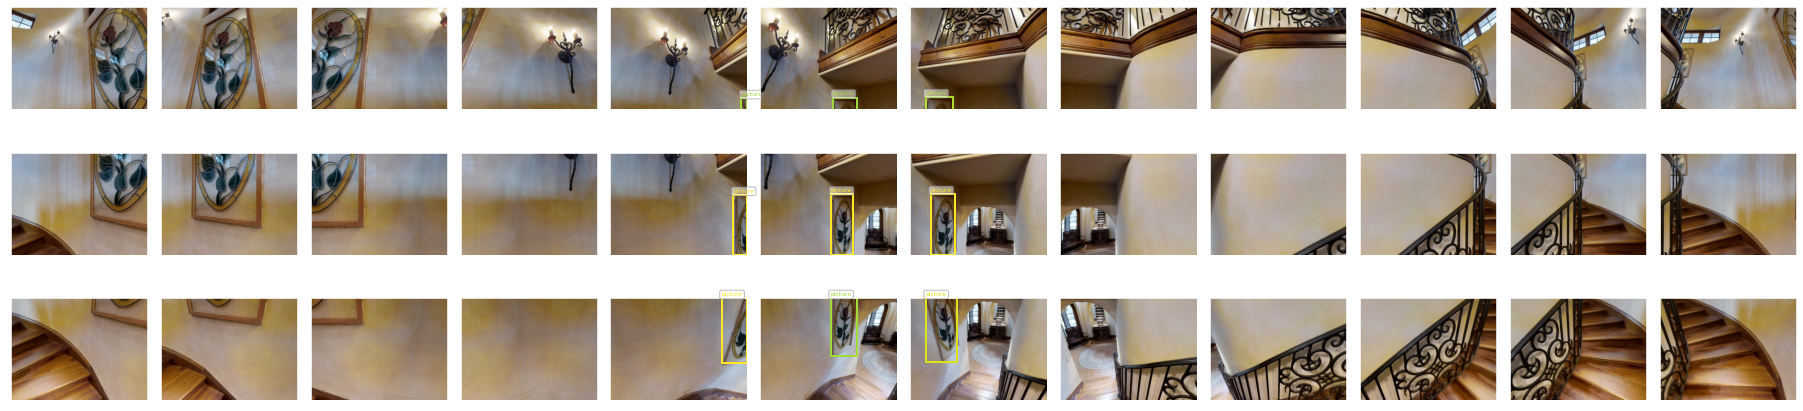

0 17e450ed7bd2429b81d50ebe770937aa False
1 8fca205ff4f740c8ad4e01e2796db860 True
2 81410b8ac62540f18cf11e409ceff9b2 False
Go down four stairs. Go down three stairs. Go to the wood bench. Go to the flower vase. Go to the round wood doorway. Go to the dining table. 


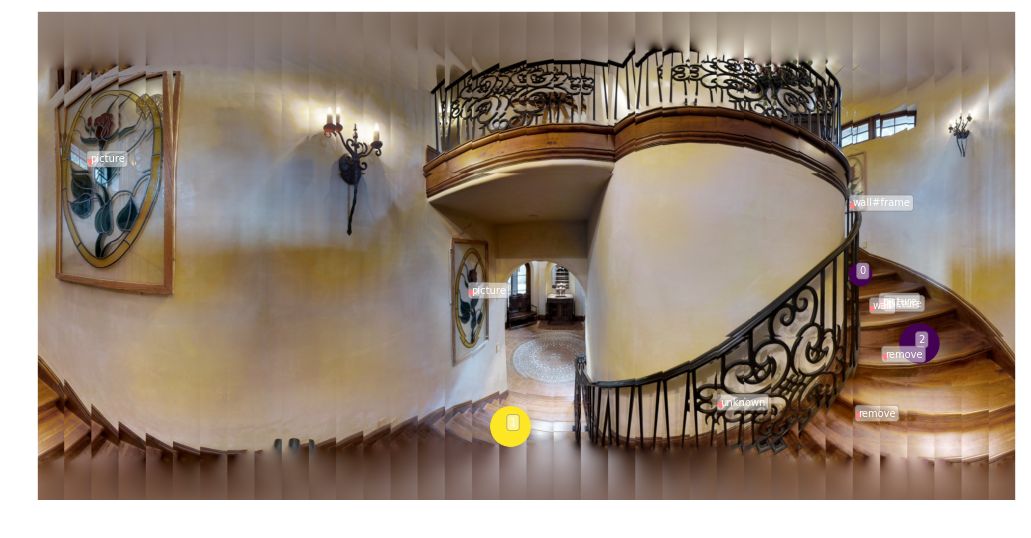

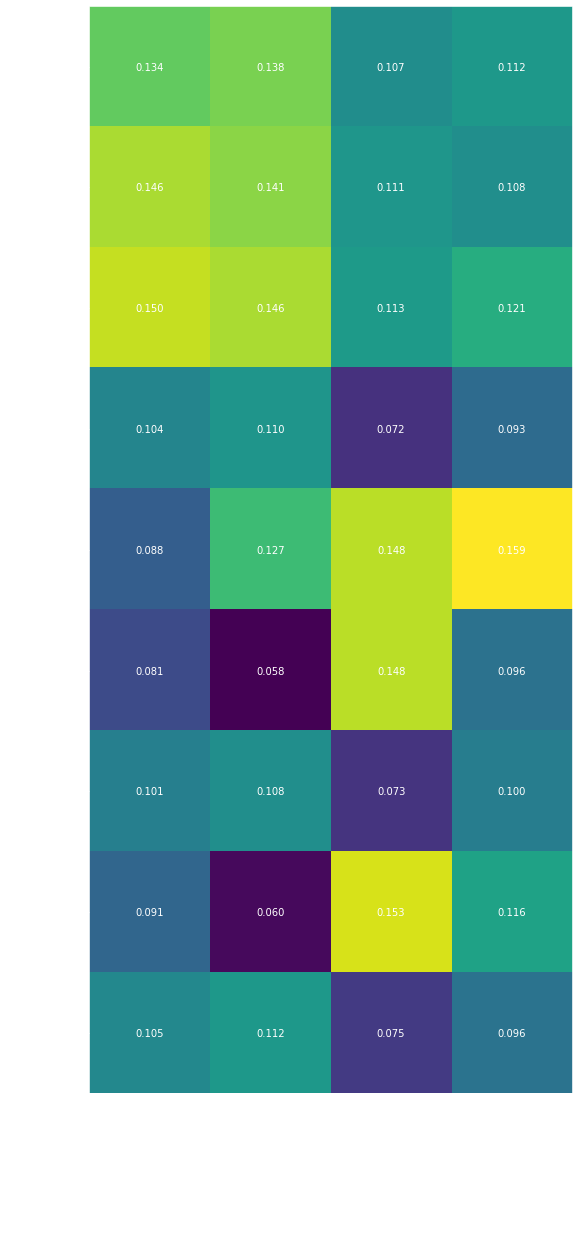

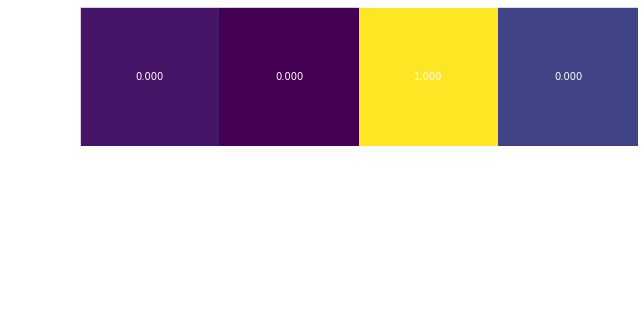

In [92]:
# make_plots(info['scan'], info['viewpoint'])
make_plots(info, trajectory, instruction, viewpoint_indices, obj_names, attn, viewpoint_attn)

In [42]:
{x: y.shape for x, y in info['objects'].items() if x != 'names'}

{'feats': torch.Size([23, 2048, 2, 2]),
 'bboxs': torch.Size([23, 5]),
 'orients': torch.Size([23, 128])}

In [43]:
info['objects']['names']

['light',
 'light',
 'light',
 'light',
 'plant',
 'pedestal',
 'pot',
 'plant',
 'pot',
 'plant',
 'pot',
 'plant',
 'pot',
 'plant',
 'plant',
 'plant',
 'plant',
 'plant',
 'plant',
 'pedestal',
 'pedestal',
 'pedestal',
 'pedestal']

In [153]:
IALAB_MEMBER = True
IALAB_USER = 'mrearle'

if IALAB_MEMBER:
    matterport_build_path = f"/home/{IALAB_USER}/datasets/Matterport3DSimulator/build"
    metadata_script_path = f"/home/{IALAB_USER}/repos/360-visualization/metadata_parser"
else:
    matterport_build_path = f"/Matterport3DSimulator/build"  # Path to simulator
    metadata_script_path = f"/360-visualization/metadata_parser"  # Path to metadata parser of this repository


# In[4]:


if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)


# In[5]:


import MatterSim

(480, 3200, 3)


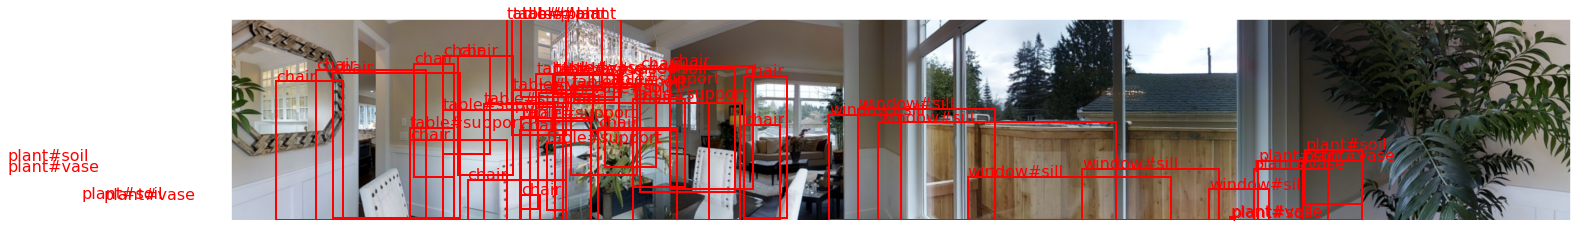

In [440]:
plt.figure(figsize=(24,12))

HEIGHT = 480
WIDTH = 640

sim = MatterSim.Simulator()
# sim.setRenderingEnabled(False)
# sim.setDiscretizedViewingAngles(True)
sim.setCameraResolution(WIDTH, HEIGHT)
sim.setCameraVFOV(VFOV)
sim.initialize()

num_views = 5
img = np.zeros((HEIGHT, WIDTH * num_views, 3), np.uint8)
for _ix in range(num_views):
    # if _ix == 0:
    #     sim.newEpisode([info['scan']], [info['viewpoint']], [0], [math.radians(-30)])
    # elif _ix % 12 == 0:
    #     sim.makeAction([0], [1.0], [1.0])
    # else:
    #     sim.makeAction([0], [1.0], [0])
    sim.newEpisode([info['scan']], [info['viewpoint']], [np.radians(60 + _ix * 70)], [math.radians(0)])

    state = sim.getState()[0]
    img[:, _ix * WIDTH:(_ix + 1) * WIDTH, :] = np.array(state.rgb, copy=True)[...,::-1]
    


# state = sim.getState()[0]
# print(state.heading, state.elevation, state.location.rel_heading)

# im = np.array(state.rgb, copy=True)
# # img[HEIGHT * (2 - e): HEIGHT * (3 - e), WIDTH * h : WIDTH * (h + 1), :] = im[..., ::-1]
# img = im[..., ::-1]
print(img.shape)
plt.imshow(img)


bbox_style = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)

for name, bbox in zip(info['objects']['names'], info['objects']['bboxs']):
    v, x, y, x1, y1 = bbox
    w = x1 - x
    h = y1 - y
    if int(v) // 12 != 0:
        continue

    x, y, w, h = int(x), int(y), int(w), int(h)

    x = ((int(v) % 12) / 12) * 5 * WIDTH + x - WIDTH
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
    plt.gca().text(x, y, name, color='red', fontsize=16, bbox=bbox_style)

In [353]:
v

tensor(8)

In [497]:
def plot_viewpoint_objs(info, scanId, viewpointId):
    WIDTH = 640
    HEIGHT = 480
    VFOV = 60
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(math.radians(VFOV))
    sim.setDiscretizedViewingAngles(True)
    sim.setBatchSize(1)
    sim.initialize()

    def transform_img(im):
        """Prep opencv 3 channel image for the network"""
        im = np.array(im, copy=True)
        im_orig = im.astype(np.float32, copy=True)
        blob = np.zeros((1, im.shape[0], im.shape[1], 3), dtype=np.float32)
        blob[0, :, :, :] = im_orig[...,::-1]
        blob = blob.transpose((0, 3, 1, 2)) / 255.0
        blob = torch.from_numpy(blob)
        # blob = preprocess(blob)
        return blob

    blobs = []
    for ix in range(36):
        if ix == 0:
            sim.newEpisode([scanId], [viewpointId], [0], [math.radians(-30)])
        elif ix % 12 == 0:
            sim.makeAction([0], [1.0], [1.0])
        else:
            sim.makeAction([0], [1.0], [0])

        state = sim.getState()[0]
        assert state.viewIndex == ix

        # Transform and save generated image
        blobs.append(transform_img(state.rgb))

    fig, axes = plt.subplots(nrows=3, ncols=12, figsize=(32, 8), gridspec_kw={'wspace': 0.1, 'hspace': 0.01})

    bbox_style = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
    for ix, blob in enumerate(blobs):
        _h = ix % 12
        _e = 2 - (ix // 12)
        ax = axes[_e, _h]
        ax.imshow(blobs[ix][0].permute(1, 2, 0).numpy())

        ax.set_xticks([])
        ax.set_yticks([])

        for name, bbox in zip(info['objects']['names'], info['objects']['bboxs']):
            v, x, y, x1, y1 = bbox
            w = x1 - x
            h = y1 - y
            if int(v) != ix:
                continue

            x, y, w, h = int(x), int(y), int(w), int(h)
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
            ax.text(x, y - 10, name, color='red', fontsize=6, bbox=bbox_style)

    plt.show()

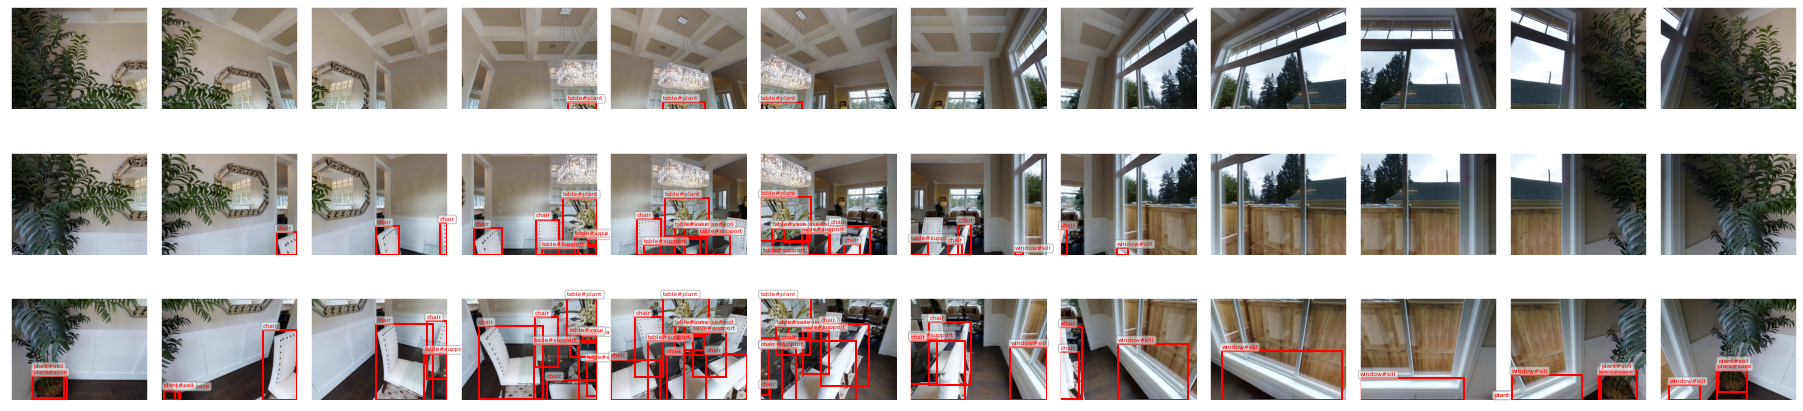

In [498]:
scanId = info['scan']
viewpointId = info['viewpoint']
plot_viewpoint_objs(info, scanId, viewpointId)

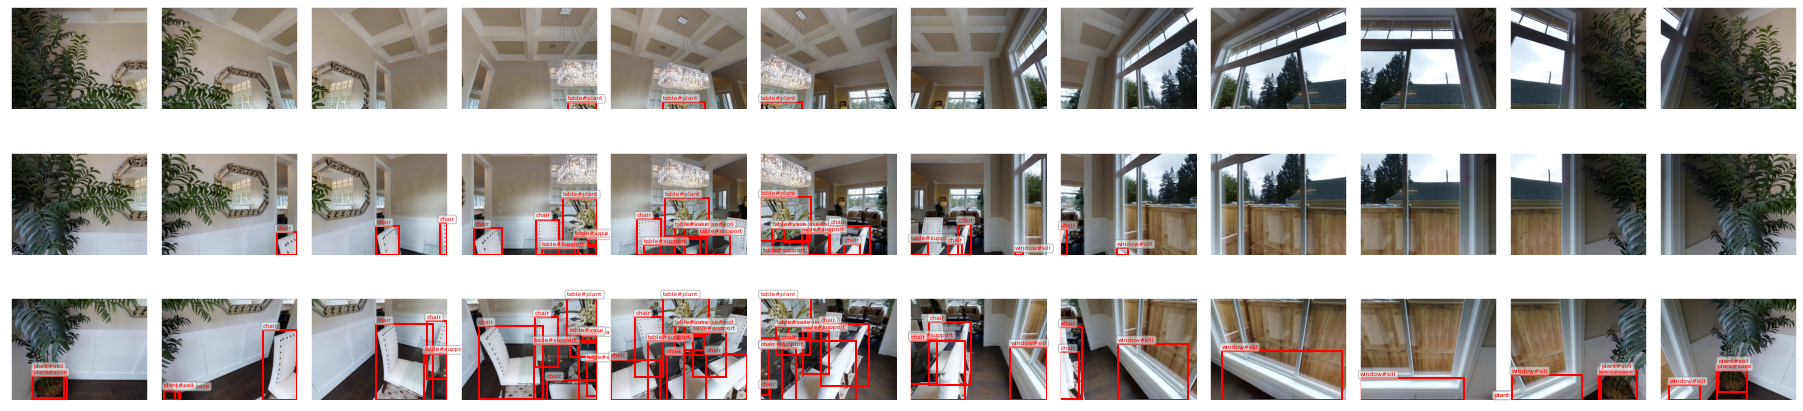